In [1]:
import pandas as pd

eeg_file = pd.read_csv("/Volumes/harris/somnotate/to_score_set/to_score_csv_files/sub-007_ses-01_recording-01_time-0-70.5h.csv")
stage_file = pd.read_csv("/Volumes/harris/somnotate/to_score_set/vis_back_to_csv/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h.csv")

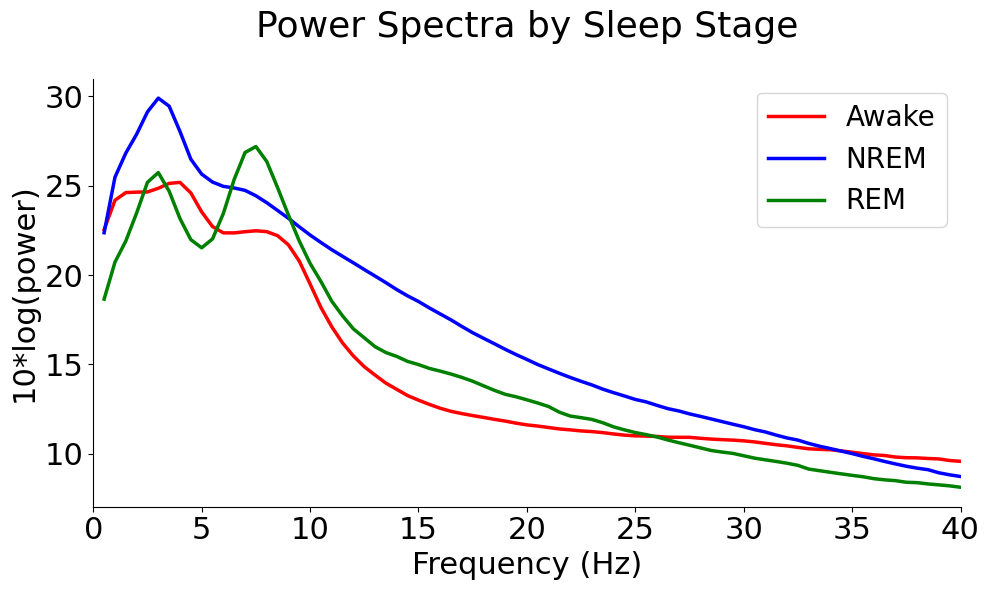

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neurodsp.spectral import compute_spectrum

def plot_power_spectra(eeg_file, stage_file, channel, sampling_rate=512):
    """
    Plot the power spectra for each sleep stage.

    Parameters:
        eeg_file (str): Path to the EEG signal CSV file.
        stage_file (str): Path to the sleep stage scoring CSV file.
        channel (str): Name of the EEG channel to use.
        sampling_rate (int): Sampling rate of the EEG signal in Hz (default: 512).
    """
    # Load EEG data
    eeg_data = eeg_file
    stages_data = stage_file

    if channel not in eeg_data.columns:
        raise ValueError(f"Channel '{channel}' not found in EEG data.")

    # Extract the relevant channel and sleep stages
    eeg_signal = eeg_data[channel].values
    sleep_stages = stages_data['sleepStage'].values

    # Verify that EEG signal and stages align
    if len(eeg_signal) != len(sleep_stages):
        raise ValueError("EEG signal and sleep stage scoring lengths do not match.")

    # Rename sleep stages and define colors
    stage_mapping = {1: 'Awake', 2: 'NREM', 3: 'REM'}
    stage_colors = {'Awake': 'red', 'NREM': 'blue', 'REM': 'green'}
    renamed_stages = np.vectorize(stage_mapping.get)(sleep_stages)

    plt.figure(figsize=(10, 6))

    for stage in stage_mapping.values():
        # Extract data for the current sleep stage
        stage_indices = np.where(renamed_stages == stage)[0]
        stage_signal = eeg_signal[stage_indices]

        # Compute power spectrum using NeuroDSP's compute_spectrum
        freqs, power = compute_spectrum(stage_signal, fs=sampling_rate, method='welch', nperseg=sampling_rate * 2)

        # Limit to 0-40 Hz range
        freq_mask = (freqs >= 0.5) & (freqs <= 40)
        freqs = freqs[freq_mask]
        power = power[freq_mask]

        # Plot log power vs frequency
        plt.plot(freqs, 10*(np.log10(power)), label=stage, color=stage_colors[stage], linewidth=2.5)


    plt.xlabel('Frequency (Hz)', fontsize=22)
    plt.ylabel('10*log(power)', fontsize=22)
    plt.title('Power Spectra by Sleep Stage', pad=30, fontsize=26)
    plt.tick_params(axis='x', labelsize=22)
    plt.tick_params(axis='y', labelsize=22)


    # Set the x-axis to start at 0
    plt.xlim([0, 40])  # Limits the x-axis from 0 to 40 Hz
    plt.xticks(np.arange(0, 41, 5))  # Set x-ticks at 5 Hz intervals

    plt.legend(fontsize=20)

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_power_spectra(eeg_file, stage_file, channel='EEG1', sampling_rate=512)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neurodsp.spectral import compute_spectrum

def plot_average_power_spectra(eeg_files, stage_files, channel, sampling_rate=512, output_file=None):
    """
    Plot the average power spectra for each sleep stage across multiple subjects.

    Parameters:
        eeg_files (list of str): Paths to the EEG signal CSV files.
        stage_files (list of str): Paths to the sleep stage scoring CSV files.
        channel (str): Name of the EEG channel to use.
        sampling_rate (int): Sampling rate of the EEG signal in Hz (default: 512).
        output_file (str): Path to save the output plot. If None, the plot is not saved.
    """
    if len(eeg_files) != len(stage_files):
        raise ValueError("The number of EEG files and stage files must match.")

    stage_mapping = {1: 'Awake', 2: 'NREM', 3: 'REM'}
    stage_colors = {'Awake': 'red', 'NREM': 'blue', 'REM': 'green'}
    all_spectra = {stage: [] for stage in stage_mapping.values()}

    for eeg_file, stage_file in zip(eeg_files, stage_files):
        # Load EEG and stage data
        eeg_data = pd.read_csv(eeg_file)
        stages_data = pd.read_csv(stage_file)

        if channel not in eeg_data.columns:
            raise ValueError(f"Channel '{channel}' not found in EEG data.")

        # Extract the relevant channel and sleep stages
        eeg_signal = eeg_data[channel].values
        sleep_stages = stages_data['Stage'].values

        # Verify that EEG signal and stages align
        if len(eeg_signal) != len(sleep_stages):
            raise ValueError("EEG signal and sleep stage scoring lengths do not match.")

        renamed_stages = np.vectorize(stage_mapping.get)(sleep_stages)

        for stage in stage_mapping.values():
            # Extract data for the current sleep stage
            stage_indices = np.where(renamed_stages == stage)[0]
            stage_signal = eeg_signal[stage_indices]

            # Compute power spectrum using NeuroDSP's compute_spectrum
            freqs, power = compute_spectrum(stage_signal, fs=sampling_rate, method='welch', nperseg=sampling_rate * 2)

            # Limit to 0-40 Hz range
            freq_mask = (freqs >= 0) & (freqs <= 40)
            freqs = freqs[freq_mask]
            power = power[freq_mask]

            # Store power for averaging
            all_spectra[stage].append(power)

    plt.figure(figsize=(10, 6))

    for stage in stage_mapping.values():
        # Compute average and standard deviation of power spectra
        stage_powers = np.array(all_spectra[stage])
        avg_power = np.mean(stage_powers, axis=0)
        std_power = np.std(stage_powers, axis=0)

        # Plot average log power and shaded area for standard deviation
        plt.plot(freqs, 10 * np.log10(avg_power), label=stage, color=stage_colors[stage])
        plt.fill_between(freqs, 10 * np.log10(avg_power - std_power), 10 * np.log10(avg_power + std_power), 
                         color=stage_colors[stage], alpha=0.3)

    plt.xlabel('Frequency (Hz)', fontsize=22)
    plt.ylabel('10*log(Power)', fontsize=22)
    plt.title('Average Power Spectra by Sleep Stage', pad=30, fontsize=26)
    plt.tick_params(axis='x', labelsize=22)
    plt.tick_params(axis='y', labelsize=22)
    plt.legend(fontsize=22)

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    # Save the plot if output_file is provided
    if output_file:
        plt.savefig(output_file, dpi=300)
        print(f"Plot saved to {output_file}")

    plt.show()

# Example usage:
# plot_average_power_spectra(['eeg_data1.csv', 'eeg_data2.csv'], ['stages1.csv', 'stages2.csv'], channel='Fz', sampling_rate=512, output_file='output_plot.png')

